In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from transformers import AutoTokenizer, T5EncoderModel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

c:\Users\Gabriel Faundez\AppData\Local\pypoetry\Cache\virtualenvs\movie-recommender-qU7K9L6K-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ASSETS_PATH = (Path.cwd() / ".." / "assets").absolute().resolve()

In [3]:
movies = pd.read_csv(
    ASSETS_PATH / "movies.csv",
    index_col=0,
    dtype={
        "movieId": "int32",
    }
    )
movies.loc[:, "genres"] = movies["genres"].str.lower().str.split("|").map(lambda x: np.array(x).astype(str))
movies.loc[:, "Director"] = movies.loc[:, "Director"].str.lower()
movies.loc[:, "Origin/Ethnicity"] = movies.loc[:, "Origin/Ethnicity"].str.lower()
movies.dropna(subset=["Title"], inplace=True)
movies.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,movieId,title,genres
5,1903,alice in wonderland,american,cecil hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",1032,alice in wonderland,"[adventure, animation, children, fantasy, musi..."


In [4]:
#  get unique genres
unique_genres = np.unique(np.concatenate(movies["genres"].values))
unique_genres.sort()
unique_genres

array(['(no genres listed)', 'action', 'adventure', 'animation',
       'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
       'film-noir', 'horror', 'imax', 'musical', 'mystery', 'romance',
       'sci-fi', 'thriller', 'war', 'western'], dtype='<U18')

In [5]:
reverse_genres = {i: genre for i, genre in enumerate(unique_genres)}
reverse_genres

{0: '(no genres listed)',
 1: 'action',
 2: 'adventure',
 3: 'animation',
 4: 'children',
 5: 'comedy',
 6: 'crime',
 7: 'documentary',
 8: 'drama',
 9: 'fantasy',
 10: 'film-noir',
 11: 'horror',
 12: 'imax',
 13: 'musical',
 14: 'mystery',
 15: 'romance',
 16: 'sci-fi',
 17: 'thriller',
 18: 'war',
 19: 'western'}

In [6]:
origins_and_ethnicities = np.unique(movies.loc[:, "Origin/Ethnicity"])

origins_and_ethnicities_encoder = OneHotEncoder()
origins_and_ethnicities_encoder.fit(
    origins_and_ethnicities.reshape(-1, 1) 
)
origins_and_ethnicities

array(['american', 'australian', 'bangladeshi', 'bengali', 'bollywood',
       'british', 'canadian', 'chinese', 'hong kong', 'japanese',
       'kannada', 'malayalam', 'russian', 'south_korean', 'tamil',
       'telugu'], dtype=object)

In [7]:
directors = np.unique(movies.loc[:, "Director"])
directors_encoder = LabelEncoder()
directors_encoder.fit(directors)
directors

array(['5 directors', 'a. m. jothi krishna', 'aaron blaise, bob walker',
       ..., '\xa0ranjith', '\xa0vinayan', 'émile gaudreault'],
      dtype=object)

Encode genres as a list of integers

In [8]:
movies_preprocessed = pd.DataFrame(
    columns=[
        "movie_id",
        "genres_vector",
        "plot_embedding",
        "title_embedding",
        "genre_embedding",
        "cast_embedding",
        "origin_and_ethnicity",
        "directors",
        "release_year"
        ],
    index=movies.index
)

In [9]:
model = T5EncoderModel.from_pretrained("t5-small")
tokenizer = AutoTokenizer.from_pretrained("t5-small")

def tokenize_text(text):
    input = tokenizer(text, return_tensors="pt")
    output = model.encoder.embed_tokens(input.input_ids)
    result_vector = output.mean(dim=1).detach().numpy()[0]
    return result_vector.reshape(1, -1)[0]

In [10]:
movies_preprocessed.loc[:, "movie_id"] = movies.loc[:, "movieId"]
movies_preprocessed.loc[:, "genres_vector"] = movies.loc[:, "genres"].map(lambda x: np.isin(unique_genres, x).astype(int))
movies_preprocessed.loc[:, "origin_and_ethnicity"] = movies.loc[:, "Origin/Ethnicity"].apply(lambda x: origins_and_ethnicities_encoder.transform(
    np.array([x]).reshape(-1, 1)
).toarray().astype(int)[0])
movies_preprocessed.loc[:, "directors"] = directors_encoder.transform(movies.loc[:, "Director"])
movies_preprocessed.loc[:, "release_year"] = movies.loc[:, "Release Year"]
movies_preprocessed.loc[:, "plot_embedding"] = movies.loc[:, "Plot"].map(tokenize_text)
movies_preprocessed.loc[:, "title_embedding"] = movies.loc[:, "Title"].map(tokenize_text)
movies_preprocessed.loc[:, "genre_embedding"] = movies.loc[:, "Genre"].map(tokenize_text)
movies_preprocessed.loc[:, "cast_embedding"] = movies.loc[:, "Cast"].astype(str).map(tokenize_text)
movies_preprocessed

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


,movie_id,genres_vector,plot_embedding,title_embedding,genre_embedding,cast_embedding,origin_and_ethnicity,directors,release_year
5,1032,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[1.0747961, 1.5417103, 3.3829744, -4.3463964, ...","[8.66183, 0.48053852, 5.6305804, -11.933036, -...","[-16.3125, 3.0078125, 19.3125, 0.09375, 4.0468...","[-5.0833335, 2.3300781, 11.458333, 14.072917, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",280,1903
6,6990,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1.4725342, 0.69198066, -0.056790404, -1.97503...","[3.7890625, 0.045898438, 1.1870117, 2.328125, ...","[11.21875, -0.1875, -17.8125, 10.78125, -8.046...","[8.293945, 4.5976562, 6.7128906, 5.84375, 2.53...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",652,1903
27,2648,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[-5.869945, 1.4494486, 6.763557, -2.8428166, 0...","[2.225, 1.328125, 0.475, -12.6, -8.59375, 1.95...","[-16.3125, 3.0078125, 19.3125, 0.09375, 4.0468...","[-3.9765625, 2.3059082, 8.041992, 1.4865723, 6...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",945,1910
31,48,"[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[1.3125185, 0.32857797, 3.5412583, 0.79371655,...","[7.3046875, 5.5195312, 4.611328, -0.0078125, 3...","[6.9375, 0.5833333, 0.29166666, 10.635417, -2....","[-0.7644231, 1.1237981, 7.7929688, 3.7475963, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2202,1910
43,7208,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[2.8029566, 0.67433685, 3.666039, 0.3530215, 1...","[5.4568014, 4.451287, 4.2766542, 3.6640625, -0...","[13.03125, -5.53125, -25.9375, 8.125, -12.9843...","[-17.46875, 4.7070312, 18.46875, 6.671875, 4.7...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1391,1912
...,...,...,...,...,...,...,...,...,...
32160,107406,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.45466956, 0.0753616, 0.5181349, -0.94418067...","[17.40625, 1.4238281, -12.6875, 2.6875, -4.699...","[-16.3125, 3.0078125, 19.3125, 0.09375, 4.0468...","[4.7921877, 3.1371093, 2.184375, 9.54375, 2.12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",208,2013
32205,120919,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8121655, -0.06903314, 0.61284846, -2.290546...","[0.91875, 1.396875, 5.1375, 4.384375, 3.339770...","[-16.3125, 3.0078125, 19.3125, 0.09375, 4.0468...","[4.3454027, 1.2602164, -5.084435, -4.6490383, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1011,2014
32296,159061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[2.471121, 0.28523055, 1.871542, -1.1815534, 0...","[5.2875, 1.50625, 2.2375, -9.9, -6.221875, -5....","[-16.3125, 3.0078125, 19.3125, 0.09375, 4.0468...","[5.4519157, -1.9406621, 1.3963914, -2.6129093,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1572,2016
32297,158783,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2.2919543, -0.39118236, 3.9974883, -1.1042542...","[11.1375, 2.025, 3.05, 8.5625, 0.903125, 0.665...","[-16.3125, 3.0078125, 19.3125, 0.09375, 4.0468...","[1.7336154, 1.8648003, 1.9288194, -9.211805, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1637,2016


In [11]:
#  Visualize embeddings
from numpy.typing import NDArray

def plot_embeddings(embeddings: NDArray):
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])

def plot_embeddings_pca(embeddings: NDArray):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])

    

In [12]:
general_views = pd.read_csv(ASSETS_PATH / "general_view_count.csv", index_col=0)
general_views.head(1)

,views
movie_id,
356,329


In [13]:
movies_preprocessed_final = movies_preprocessed.merge(general_views, left_on="movie_id", right_on="movie_id", how="inner")
movies_preprocessed_final["mean_embeddings"] = movies_preprocessed_final.loc[:, ["plot_embedding", "title_embedding", "genre_embedding", "cast_embedding"]].sum(axis=1) / 4
movies_preprocessed_final.set_index("movie_id", inplace=True)
movies_preprocessed_final.sort_index(inplace=True)

In [14]:
movies_preprocessed_final

,genres_vector,plot_embedding,title_embedding,genre_embedding,cast_embedding,origin_and_ethnicity,directors,release_year,views,mean_embeddings
movie_id,,,,,,,,,,
1,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[3.8667188, 0.77148616, 2.5875123, 0.09029625,...","[4.6835938, 2.65625, -4.828125, 3.8828125, -2....","[4.375, 7.609375, -5.0, 7.34375, -8.520833, 9....","[6.682943, -0.45328775, 4.05306, 4.525065, -0....","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1165,1995,215,"[4.902064, 2.6459558, -0.79688823, 3.9604807, ..."
2,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1.1317016, 0.65967375, 1.0458522, -0.80069464...","[-5.5104165, 5.0716147, 9.6588545, 6.7096353, ...","[7.09375, 3.6045532, -11.375, 8.7578125, -0.13...","[-0.26979166, -0.2938151, 3.8986979, 1.3197917...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1109,1995,110,"[0.61131084, 2.2605069, 0.807101, 3.9966364, -..."
3,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.6763515, 0.75590265, 2.1689253, -1.3884925,...","[5.6158853, 7.2864585, 2.0833333, 2.7942708, -...","[5.908203, 3.578125, -5.7368164, 19.59375, -7....","[-1.5609375, 4.176074, 0.8234375, 3.2525392, 0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",912,1995,52,"[2.9098754, 3.94914, -0.16528015, 6.063017, -2..."
4,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2.5669153, 0.03308752, 1.7188679, -2.6858118,...","[-3.0104167, 1.0377604, 12.28125, -2.9401042, ...","[7.0820312, 4.6210938, 2.3125, 0.125, -0.64843...","[-2.7436996, -0.3342994, -3.2990172, 5.9916835...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",701,1995,7,"[0.97370756, 1.3394105, 3.2534003, 0.12269187,..."
5,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.2889512, 0.30947247, 3.6269884, -1.8916683,...","[4.90191, 4.596354, 4.0833335, -6.3037653, -3....","[5.908203, 3.578125, -5.7368164, 19.59375, -7....","[-3.1698627, 1.7694129, 3.1015625, 7.163826, 1...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",296,1995,49,"[2.4823003, 2.5633411, 1.268767, 4.6405354, -2..."
...,...,...,...,...,...,...,...,...,...,...
180095,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[2.4688141, 0.34858036, 3.4548306, -3.1670666,...","[6.8242188, -5.84375, 12.3125, -12.71875, -8.6...","[7.0820312, 4.6210938, 2.3125, 0.125, -0.64843...","[0.5145349, 1.3344386, 0.09338663, -0.8021439,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2036,2017,3,"[4.2223997, 0.11509067, 4.543304, -4.14074, -1..."
180297,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1.5990168, 0.31159943, 3.0387983, 0.66817486,...","[11.011719, -2.2421875, -4.453125, 5.8322754, ...","[5.3717446, 2.951823, 0.9210612, 5.875, -3.815...","[-0.087740384, 1.9636419, 4.254357, -1.5244892...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",975,2017,2,"[4.4736853, 0.7462192, 0.94027287, 2.7127402, ..."
180497,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1.1905729, 0.07663419, 4.053887, 2.5265942, 1...","[8.380208, 5.6354165, 3.9375, 4.0625, -2.23307...","[9.71582, 2.7333984, -0.8671875, 3.140625, -1....","[1.6861328, 1.4753824, 4.5865884, 0.7801758, 0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2078,2017,2,"[5.2431836, 2.4802082, 2.927697, 2.6274738, -0..."


<Axes: >

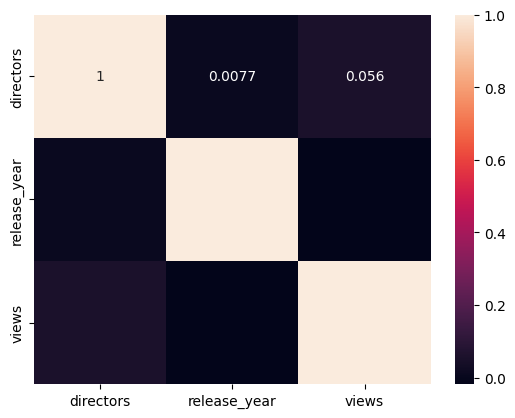

In [15]:
correlation_matrix = movies_preprocessed_final[["directors", "release_year", "views"]].corr()
sns.heatmap(correlation_matrix, annot=True)

In [16]:
movies_features = pd.DataFrame(
    columns=[
        *unique_genres,
        # *origins_and_ethnicities,
        *[f"mean_embedding_{i}" for i in range(512)],
    ],
    index=movies_preprocessed_final.index
)

In [17]:
movies_features.iloc[:, :len(unique_genres)] = movies_preprocessed_final.loc[:, "genres_vector"].values.tolist()
# movies_features.iloc[:, len(unique_genres):len(unique_genres)+len(origins_and_ethnicities)] = movies_preprocessed_final.loc[:, "origin_and_ethnicity"].values.tolist()
movies_features.iloc[:, len(unique_genres):] = movies_preprocessed_final.loc[:, "mean_embeddings"].values.tolist()
movies_features

,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,mean_embedding_502,mean_embedding_503,mean_embedding_504,mean_embedding_505,mean_embedding_506,mean_embedding_507,mean_embedding_508,mean_embedding_509,mean_embedding_510,mean_embedding_511
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,...,-5.049554,6.125811,-2.590333,-2.572237,3.453376,-1.278451,-1.832908,2.585461,-0.852638,6.303458
2,0,0,1,0,1,0,0,0,0,1,...,-4.102851,2.557875,3.352417,1.120927,5.41615,-3.60591,2.080977,4.917623,-4.419924,7.407266
3,0,0,0,0,0,1,0,0,0,0,...,-5.881861,-6.43876,-2.381506,3.996,7.904838,-2.636828,0.404177,6.368876,-2.302196,6.436986
4,0,0,0,0,0,1,0,0,1,0,...,-1.443527,-1.154354,-2.578665,-0.66469,5.589701,-1.427754,1.578732,2.466406,0.887595,5.789334
5,0,0,0,0,0,1,0,0,0,0,...,-3.772574,0.38151,-3.179269,-1.674728,6.726957,-2.646829,-1.850159,2.334108,-0.702055,7.512578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180095,0,0,0,0,0,0,0,0,1,0,...,-2.384616,-8.372534,-3.134111,5.792111,9.033531,-0.497339,4.806402,0.691382,4.749726,5.930727
180297,0,0,0,0,0,1,0,0,1,0,...,-1.094077,2.694034,1.950521,-1.688273,8.033785,-3.715811,2.011293,3.184721,-3.316417,9.639634
180497,0,0,0,0,0,0,0,0,1,0,...,-1.881445,2.89197,2.676779,-1.630884,6.15431,-3.160019,2.356874,2.193135,-7.044788,9.077114


<Axes: >

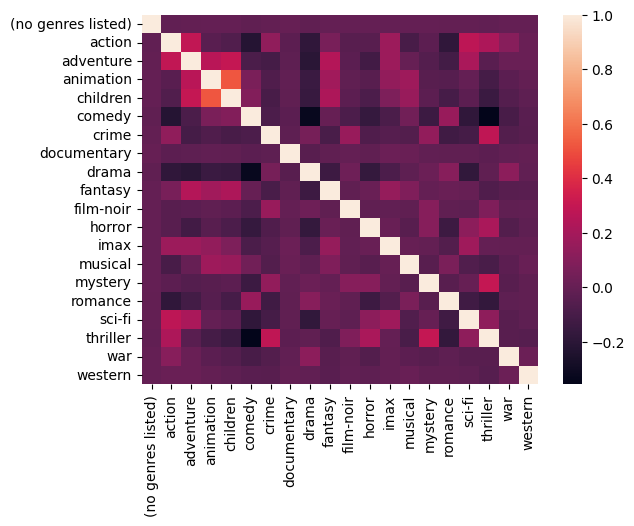

In [18]:
sns.heatmap(movies_features.iloc[:, :len(unique_genres)].corr(), annot=False)

In [19]:
import annoy
from annoy import AnnoyIndex
from numpy.typing import NDArray

def build_annoy_index(data: NDArray, vector_size, metric="angular"):
    annoy_index = AnnoyIndex(vector_size, metric=metric)
    for i, vector in enumerate(data):
        annoy_index.add_item(i, vector)
    annoy_index.build(100)
    return annoy_index

In [20]:
vector_size = movies_features.shape[1]
vector_size

532

In [21]:
index = build_annoy_index(
    movies_features.values,
    vector_size,
    metric="euclidean"
)

In [22]:
from typing import List
def map_recommendations(
        numerical_index: int,
        recommendations: List[int],
        movies: pd.DataFrame,
        movies_features: pd.DataFrame
        ):
        mapped_recommendations = []
        for recommendation in recommendations:
                movie_id = movies_features.index[recommendation]
                movie_title = movies[movies["movieId"] == movie_id]["Title"].values
                mapped_recommendations.append(
                        {
                                "movie_id": movie_id,
                                "movie_title": movie_title[0].capitalize(),
                                "movie_genres": "|".join(movies[movies["movieId"] == movie_id]["genres"].values[0]),
                                "similarity": index.get_distance(numerical_index, recommendation),
                                "views": movies_preprocessed_final.loc[movie_id, "views"]
                        }
                )
        return mapped_recommendations

In [23]:
target_movie_numerical_index = 55
movie_id=movies_features.index[target_movie_numerical_index]
print(
        f"Target movie: {movies[movies['movieId'] == movie_id]['Title'].values[0]}",
        f"Genres: {movies[movies['movieId'] == movie_id]['genres'].values[0]}",
        sep="\n"
)

recommendations = index.get_nns_by_item(target_movie_numerical_index, 10)
map_recommendations(target_movie_numerical_index, recommendations, movies, movies_features)

Target movie: black sheep
Genres: ['comedy']


[{'movie_id': 88,
  'movie_title': 'Black sheep',
  'movie_genres': 'comedy',
  'similarity': 0.0,
  'views': 16},
 {'movie_id': 30894,
  'movie_title': 'White noise',
  'movie_genres': 'drama|horror|mystery|sci-fi|thriller',
  'similarity': 77.24343872070312,
  'views': 8},
 {'movie_id': 5361,
  'movie_title': 'White fang',
  'movie_genres': 'adventure',
  'similarity': 78.33405303955078,
  'views': 2},
 {'movie_id': 8451,
  'movie_title': 'Blackboard jungle',
  'movie_genres': 'drama',
  'similarity': 78.46478271484375,
  'views': 2},
 {'movie_id': 86,
  'movie_title': 'White squall',
  'movie_genres': 'action|adventure|drama',
  'similarity': 79.25835418701172,
  'views': 15},
 {'movie_id': 2132,
  'movie_title': "Who's afraid of virginia woolf?",
  'movie_genres': 'drama',
  'similarity': 79.67005920410156,
  'views': 7},
 {'movie_id': 48696,
  'movie_title': 'Little children',
  'movie_genres': 'drama|romance',
  'similarity': 79.8414306640625,
  'views': 4},
 {'movie_id': 1959,
 

Estoy usando distancia euclidiana dado que los embeddings de texto generados por google/flan-t5-small son de 512 dimensiones. Dado que estos vectores son una representación de la semántica de las palabras, la distancia euclidiana es una buena métrica para medir la similitud entre dos textos.

Se tomo el supuesto de que usar bag of words para el problema era lo suficientemente bueno, asi que se promediaron los embeddings de cada palabra en los distintos textos y se calculo la distancia euclidiana entre los embeddings de cada texto.

Ademas se agrego información de los géneros de las películas, dado que se considero que es un factor importante para la recomendación de películas. Ademas esto ayuda a resolver desempates entre películas que tienen la misma distancia euclidiana entre sus embeddings.

Se ignoraron ciertas variables como el año de lanzamiento de la película, director, etc. dado que complicaban el problema y no se encontró una forma de usarlas para mejorar la recomendación de manera significativa.

In [24]:
# Store artifacts

movies_processed = movies.set_index(
    "movieId"
).to_csv(ASSETS_PATH / "movies_processed.csv")
movies_features.to_csv(ASSETS_PATH / "movies_features.csv")
index.save(str(ASSETS_PATH / "annoy_index.ann"))


True